In [1]:
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from mrcnn.utils import Dataset
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image
from numpy import expand_dims
from matplotlib import pyplot as plt
from mrcnn import visualize
import skimage.io

class FractureDataset(Dataset):
    def load_dataset(self, is_train=True):
        self.add_class("dataset", 1, "Fracture")
        images_dir = 'H://Projects//Fracture detection maskRCNN//data//'
        annotations_dir =  'H://Projects//Fracture detection maskRCNN//annots//'
        c=0
        for filename in listdir(images_dir):
            c+=1
            image_id = filename.split('.')[0]
            if is_train and c >= 55:
                continue
            if not is_train and c < 55:
                continue
            img_path = images_dir + filename
            ann_path = annotations_dir + image_id + '.xml'
            self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)

    def extract_boxes(self, filename):
        tree = ElementTree.parse(filename)
        root = tree.getroot()
        boxes = list()
        for box in root.findall('.//bndbox'):
            xmin = int(box.find('xmin').text)
            ymin = int(box.find('ymin').text)
            xmax = int(box.find('xmax').text)
            ymax = int(box.find('ymax').text)
            coors = [xmin, ymin, xmax, ymax]
            boxes.append(coors)
        
        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        return boxes, width, height

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        path = info['annotation']
        boxes, w, h = self.extract_boxes(path)
        masks = zeros([h, w, len(boxes)], dtype='uint8')
        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e, i] = 1
            class_ids.append(self.class_names.index('Fracture'))
        return masks, asarray(class_ids, dtype='int32')

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

class FractureConfig(Config):
    NAME = "fracture_cfg"
    NUM_CLASSES = 1 + 1
    STEPS_PER_EPOCH = 60
class PredictionConfig(Config):
    NAME = "fracture_cfg"
    NUM_CLASSES = 1 + 1
    IMAGES_PER_GPU = 1

train_set = FractureDataset()
train_set.load_dataset( is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))
test_set = FractureDataset()
test_set.load_dataset( is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))


C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning: Passi

Train: 54
Test: 8


Using TensorFlow backend.


In [2]:
config = FractureConfig()
config.display()
model = MaskRCNN(mode='training', model_dir='./', config=config)
model.load_weights('mask_rcnn_coco.h5', by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])
model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=7, layers='heads')


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/7
60/60 [==============================] - 7002s 117s/step - loss: 3.3663 - rpn_class_loss: 0.0483 - rpn_bbox_loss: 1.8082 - mrcnn_class_loss: 0.1211 - mrcnn_bbox_loss: 0.7878 - mrcnn_mask_loss: 0.6010 - val_loss: 1.9216 - val_rpn_class_loss: 0.0250 - val_rpn_bbox_loss: 0.4971 - val_mrcnn_class_loss: 0.1100 - val_mrcnn_bbox_loss: 0.7178 - val_mrcnn_mask_loss: 0.5717
Epoch 2/7
60/60 [==============================] - 6735s 112s/step - loss: 1.4645 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 0.3102 - mrcnn_class_loss: 0.1030 - mrcnn_bbox_loss: 0.5352 - mrcnn_mask_loss: 0.4981 - val_loss: 1.9722 - val_rpn_class_loss: 0.0260 - val_rpn_bbox_loss: 0.7890 - val_mrcnn_class_loss: 0.0656 - val_mrcnn_bbox_loss: 0.6047 - val_mrcnn_mask_loss: 0.4870
Epoch 3/7
60/60 [==============================] - 6739s 112s/step - loss: 1.1328 - rpn_class_loss: 0.0187 - rpn_bbox_loss: 0.2015 - mrcnn_class_loss: 0.0845 - mrcnn_bbox_loss: 0.3677 - mrcnn_mask_loss: 0.4605 - val_loss: 1.8081 - val_rpn_class_l

In [8]:
import keras
model.keras_model.save_weights("mask_rcnn_fracture___.h5")

In [2]:
cfg = PredictionConfig()
model = MaskRCNN(mode='inference', model_dir='./', config=cfg)
model.load_weights(r"mask_rcnn_fracture___.h5", by_name=True)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [3]:
def test_images( model, cfg):
    import os
    import cv2
    from mrcnn import visualize
    import skimage.io
    import os
    
    IMAGE_DIR=r"H:\Projects\Fracture detection maskRCNN\test_images"
    file_names = next(os.walk(IMAGE_DIR))[2]

    for i in range(len(next(os.walk(IMAGE_DIR))[2])):
        random_image=os.path.join(IMAGE_DIR, file_names[i])
        
        image = skimage.io.imread(random_image)
        scaled_image = mold_image(image, cfg)
        # convert image into one sample
        sample = expand_dims(scaled_image, 0)
        yhat = model.detect(sample, verbose=0)[0]
        
        r = yhat
        visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                                    class_names, r['scores'])
        
        rois = r['rois']
        mask = r['masks']
        temp=image
        mask = mask.astype(int)
        no_masks=rois.shape[0]
        rois = rois.astype(int)
        classes= r['class_ids']
        

        s=0
        temp = image
        index=0
        x1=rois[index][1]
        y1=rois[index][0]
        x2=rois[index][3]
        y2=rois[index][2]
        masked_=temp[y1:y2, x1:x2]
        plt.figure(figsize=(8,8))
        plt.title("Fracture ROI")
        plt.imshow(masked_)
        
        
        


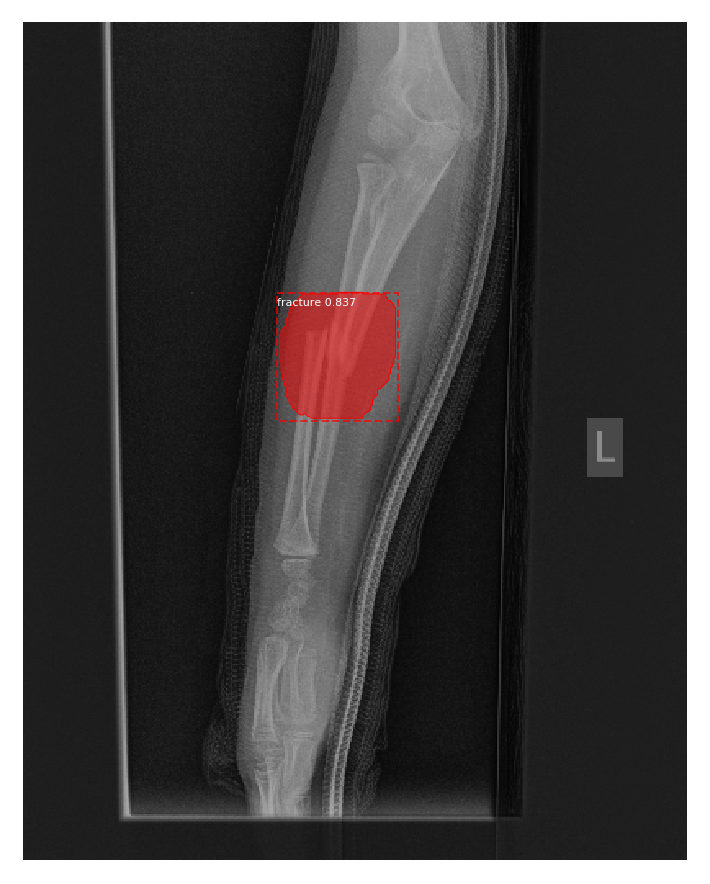

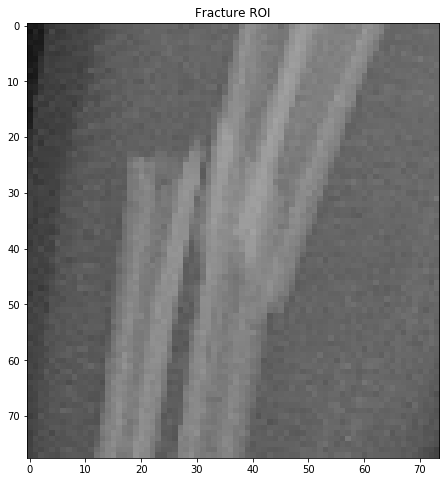

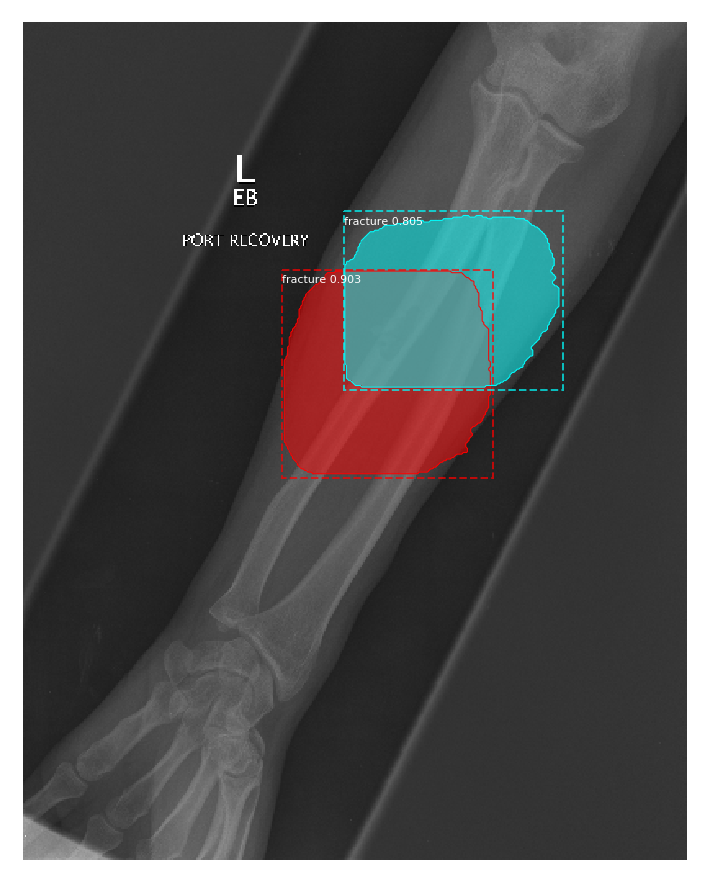

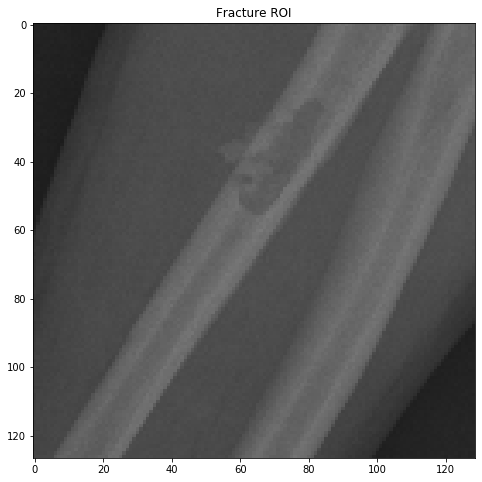

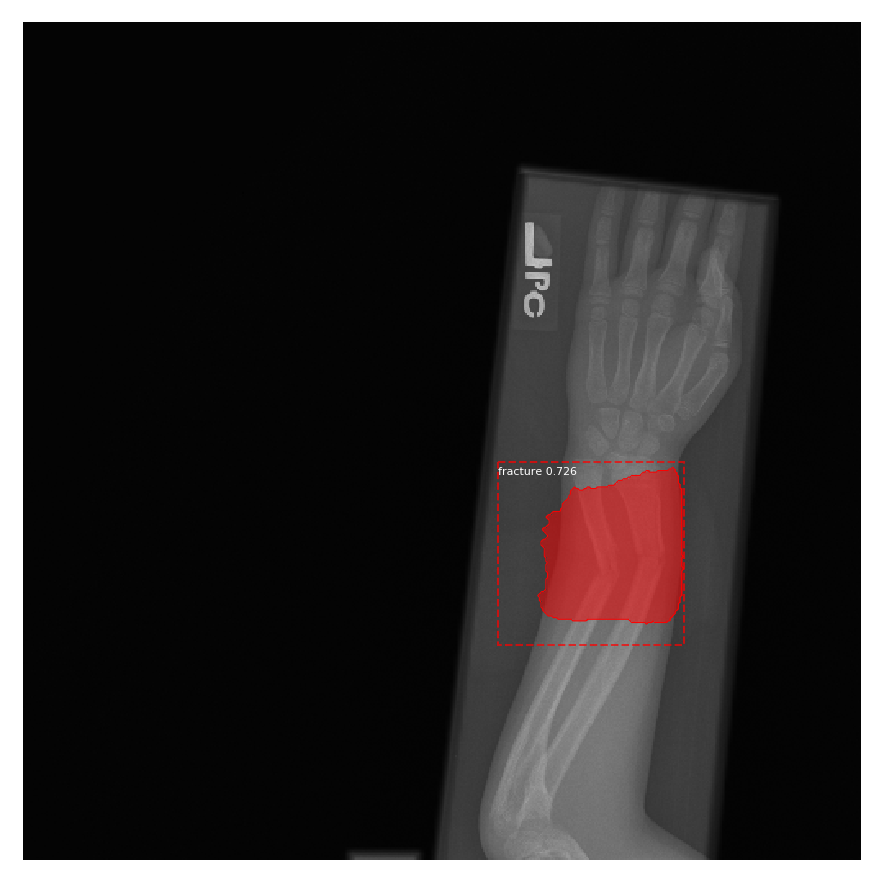

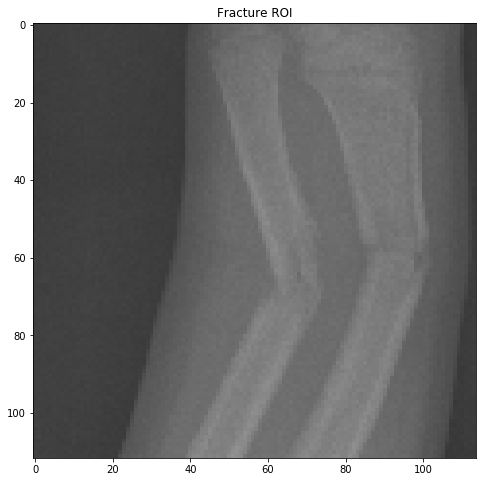

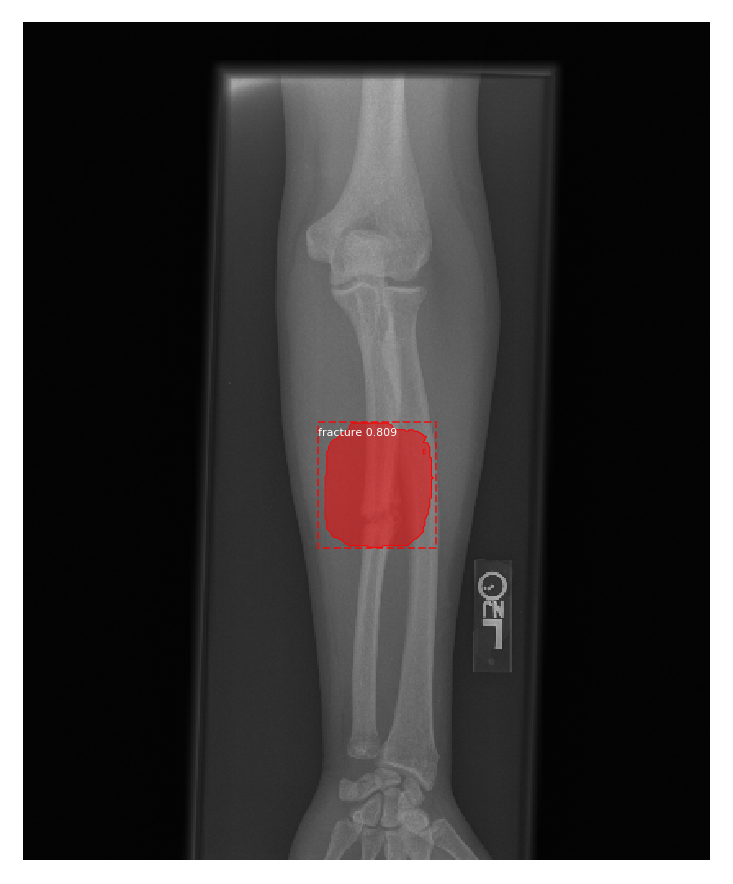

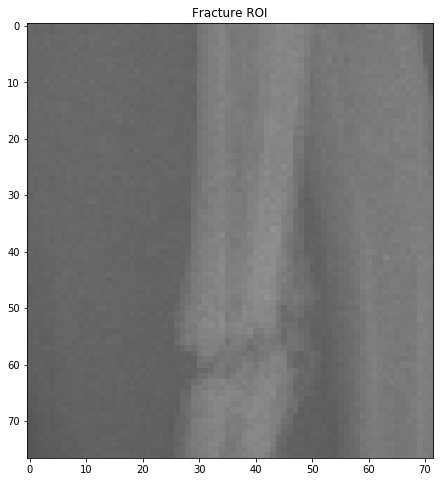

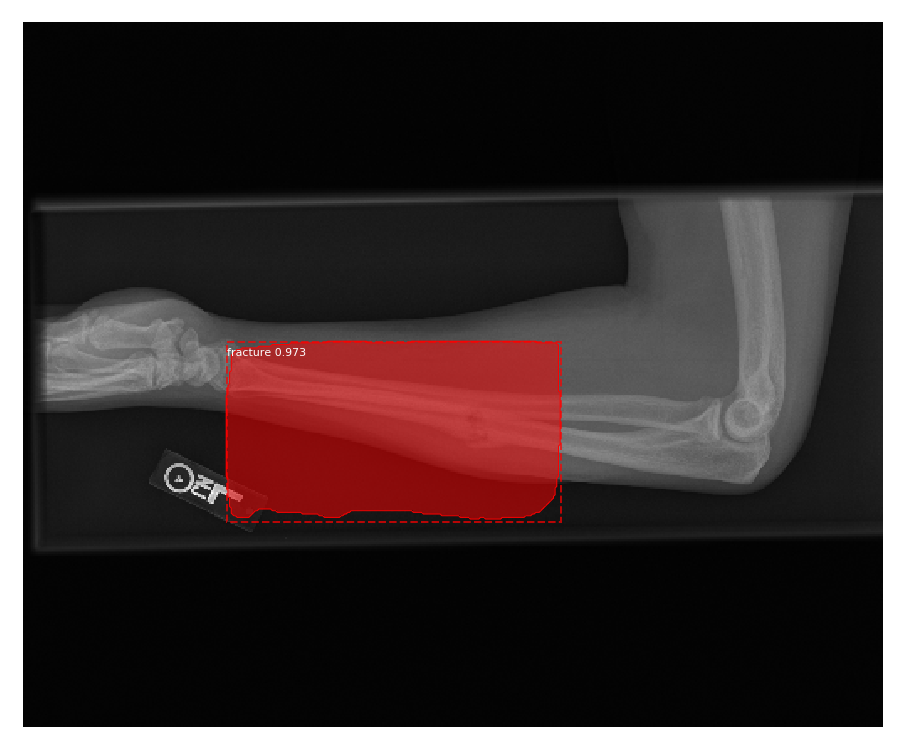

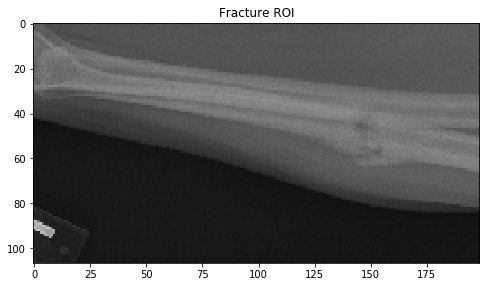

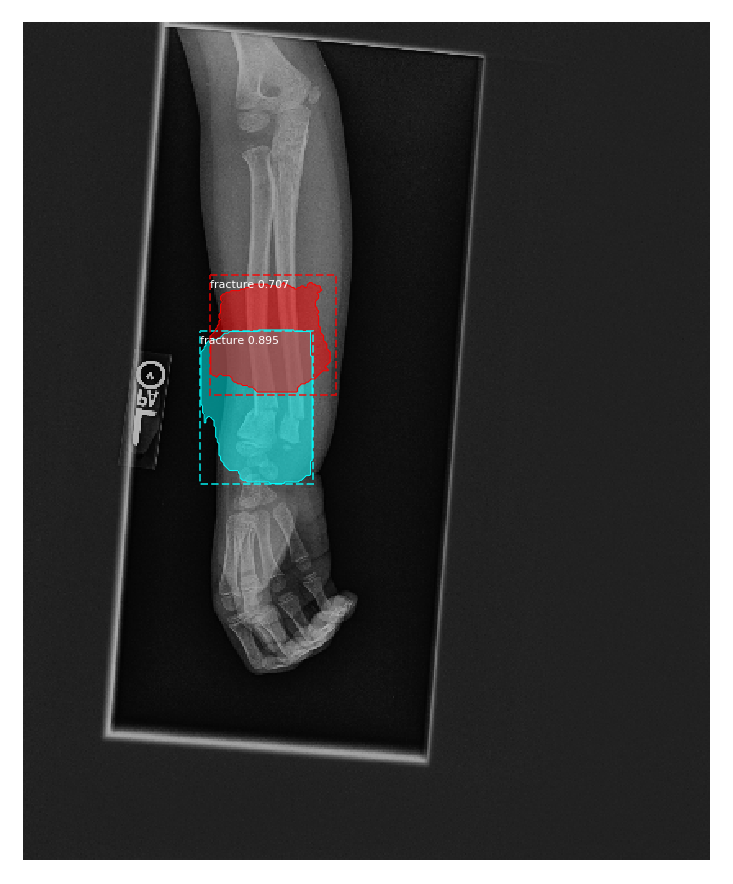

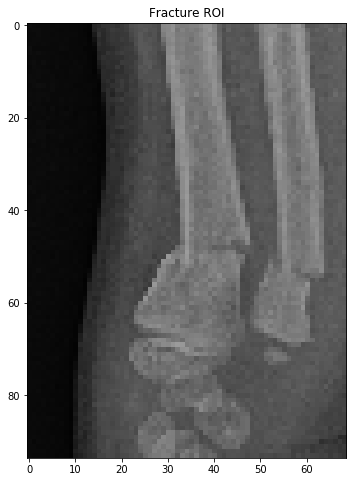

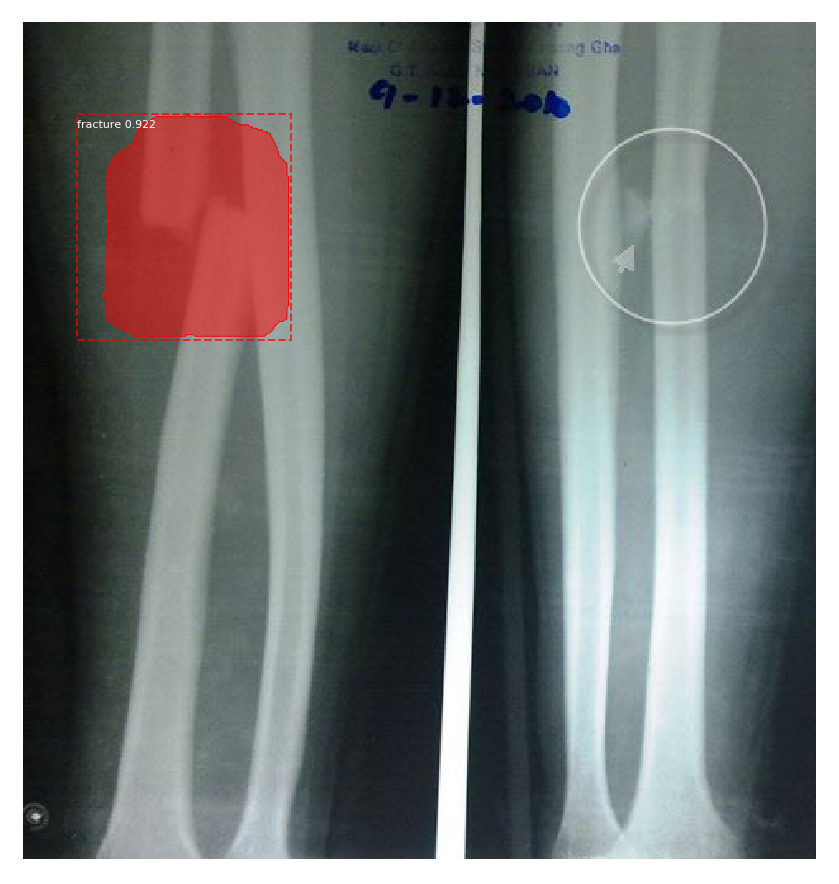

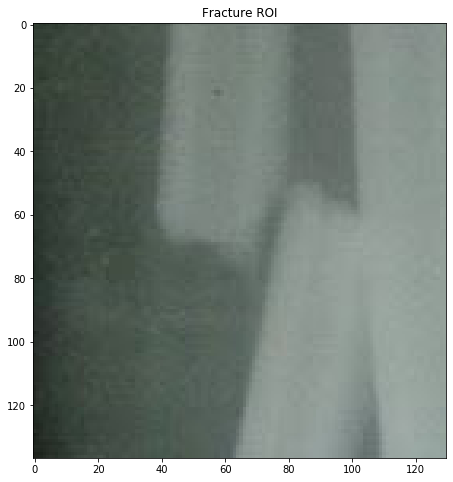

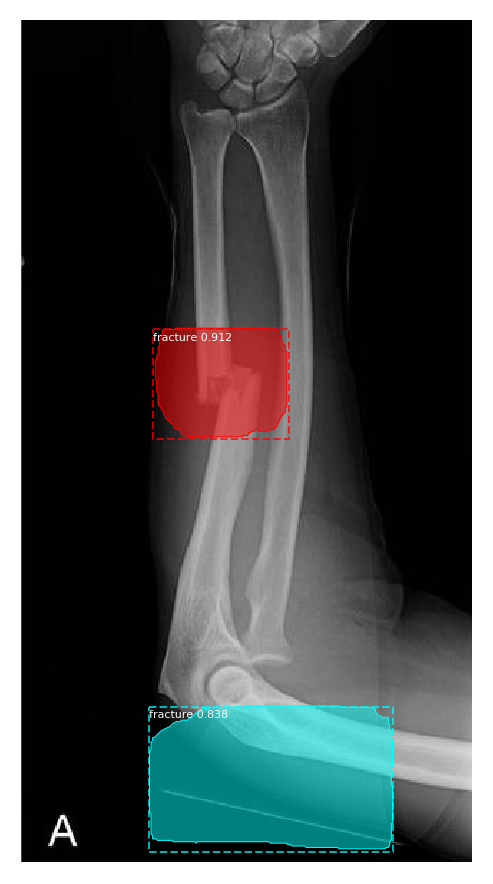

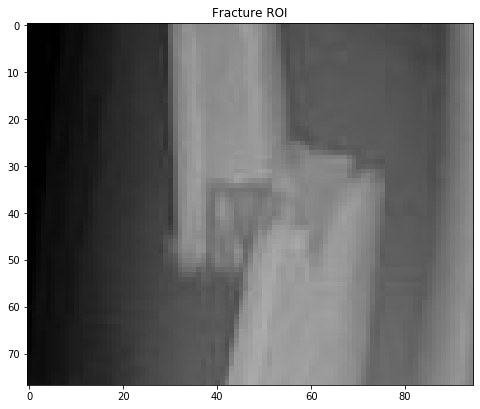

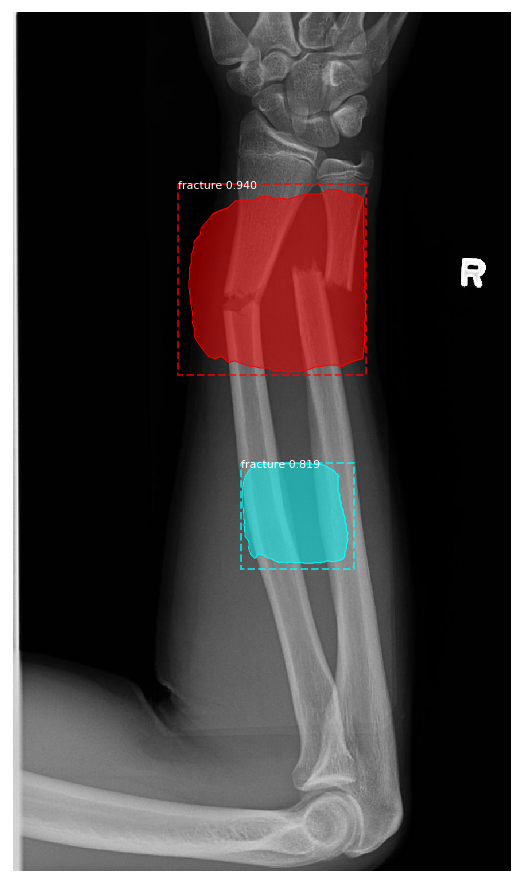

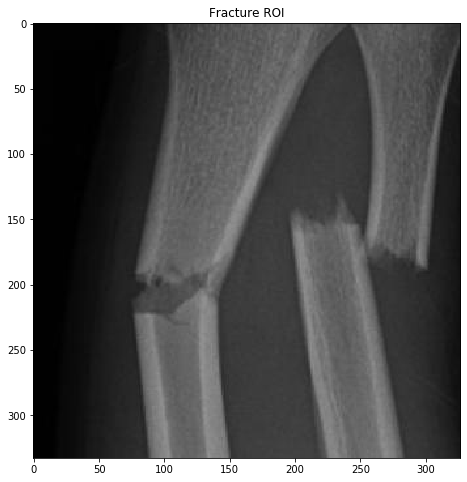

In [4]:
class_names=['background','fracture']
test_images(model, cfg)